In [0]:
import librosa
import os
import random
import numpy as np
import csv
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!ls /content/gdrive/My\ Drive/accent
os.chdir('/content/gdrive/My Drive/accent')

arabic_mfcc13.csv  cnn_model.ipynb     english_mfcc39.csv  spanish_mfcc13.csv
arabic_mfcc39.csv  english_mfcc13.csv  lstm_model.ipynb    spanish_mfcc39.csv


In [0]:
#feature extraction

def mfcc_feature(folder):

    num_data=180

    mfcc_array=[]
    label_array=[]

    for filename in os.listdir(folder):

        (rate,sig)=wav.read(folder+'/'+filename)
        
        float_sig=np.array(sig,dtype=float)
        
        normed_sig = librosa.util.fix_length(float_sig, 240000)
        normed_sig = (normed_sig - np.mean(normed_sig))/np.std(normed_sig)

        #mfcc=librosa.feature.mfcc(y=normed_sig, sr=rate, n_fft=512, hop_length=256, n_mfcc=13) #32ms #16ms #13d
        mfcc=librosa.feature.mfcc(y=normed_sig, sr=rate,n_fft=512, hop_length=256, n_mfcc=39) #39d
        #mfcc=librosa.feature.mfcc(y=normed_sig, sr=rate,n_fft=512, hop_length=256, n_mfcc=39, htk=True) #32ms #16ms #htk style
        mfcc=mfcc.reshape(mfcc.shape[1],mfcc.shape[0])
        mfcc_array.append(mfcc)

        if folder.endswith("arabic"):
            label=np.zeros((938,1),dtype=int)
            label_array.append(label)
        elif folder.endswith("english"):
            label=np.ones((938,1),dtype=int)
            label_array.append(label)
        elif folder.endswith("spanish"):
            label=np.ones((938,1),dtype=int)*2
            label_array.append(label)
        
    mfcc_array=np.array(mfcc_array)
    mfcc_array=mfcc_array.reshape(mfcc_array.shape[1]*num_data,mfcc_array.shape[2])
    print("mfcc shape:",mfcc_array.shape)

    label_array=np.array(label_array)
    label_array=label_array.reshape(label_array.shape[1]*num_data,label_array.shape[2])
    print("label shape:",label_array.shape)
    
    result=np.hstack((mfcc_array,label_array))
    print("total shape:",result.shape)

    mfcc_folder='C:/git/download/Accented speech recognition/Accent-Classifier/data/speech accent archive/mfcc'

    if folder.endswith("arabic"):
        with open(mfcc_folder+'/'+"arabic_mfcc.csv", 'w') as arabic_csv:
            np.savetxt(arabic_csv, result, delimiter=",")
    elif folder.endswith("english"):
        with open(mfcc_folder+'/'+"english_mfcc.csv", 'w') as english_csv:
            np.savetxt(english_csv, result, delimiter=",")
    elif folder.endswith("spanish"):
        with open(mfcc_folder+'/'+"spanish_mfcc.csv", 'w') as spanish_csv:
            np.savetxt(spanish_csv, result, delimiter=",")
 
mfcc_feature('C:/git/download/Accented speech recognition/Accent-Classifier/data/speech accent archive/exp/arabic')
mfcc_feature('C:/git/download/Accented speech recognition/Accent-Classifier/data/speech accent archive/exp/english')  
mfcc_feature('C:/git/download/Accented speech recognition/Accent-Classifier/data/speech accent archive/exp/spanish') 

In [0]:
def csv2data(arabic, english, spanish):
  arabic_data = np.loadtxt(arabic, delimiter = ",", dtype = np.int32)
  english_data = np.loadtxt(english, delimiter = ",", dtype = np.int32)
  spanish_data = np.loadtxt(spanish, delimiter = ",", dtype = np.int32)

  num=(168840//9984)*9984
  trin_num = num-(num//4) #126630
  test_num = num//4 #42210

  arabic_train = arabic_data[:trin_num,:]
  arabic_test = arabic_data[trin_num:trin_num+test_num,:]

  english_train = english_data[:trin_num,:]
  english_test = english_data[trin_num:trin_num+test_num,:]

  spanish_train = spanish_data[:trin_num,:]
  spanish_test = spanish_data[trin_num:trin_num+test_num,:]

  train_data = np.vstack([arabic_train,english_train,spanish_train])
  test_data = np.vstack([arabic_test,english_test,spanish_test])

  #print("train data shape:",train_data.shape)
  #print("test data shape:",test_data.shape)

  return train_data, test_data

In [0]:
class Accent_dataset(Dataset): 
  # Initialize your data, download, etc. 
  def __init__(self, csv2data):
    x_data, y_data = csv2data[:,:-1], csv2data[:,-1]

    x_data = x_data.reshape(-1, 39, 16, 16)
    y_data = y_data.reshape(-1,)

    x_data = x_data.astype(np.float32)
    y_data = y_data.astype(np.int64)

    #self.x_data = torch.cuda.FloatTensor(x_data)
    #self.y_data = torch.cuda.LongTensor(y_data)

    self.x_data = torch.from_numpy(x_data)
    self.y_data = torch.from_numpy(y_data)
    
    print("=== Dataset Download Complete !!")
    print("X shape:",self.x_data.shape)
    print("Y shape:",self.y_data.shape)

    self.len = len(x_data)

  def __getitem__(self, index): 
    return self.x_data[index], self.y_data[index] 

  def __len__(self): 
    return self.len

In [10]:
train, test = csv2data("arabic_mfcc39.csv", "english_mfcc39.csv", "spanish_mfcc39.csv")

train_dataset = Accent_dataset(train) 
test_dataset = Accent_dataset(test)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

=== Dataset Download Complete !!
X shape: torch.Size([1404, 39, 16, 16])
Y shape: torch.Size([359424])
=== Dataset Download Complete !!
X shape: torch.Size([468, 39, 16, 16])
Y shape: torch.Size([119808])


In [11]:
#device setting

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

print(device)

cuda


In [0]:
#parameters

num_epochs=200
learning_rate=0.00001
batch_size=64

In [13]:
inputs=torch.Tensor(1404, 39, 16, 16)

conv1 = nn.Conv2d(39, 32, 2, 1, 1)
pool1 = nn.MaxPool2d(2)
outputs1 = pool1(conv1(inputs))
print(outputs1.shape)

conv2 = nn.Conv2d(32, 64, 2, 1, 1)
pool2 = nn.MaxPool2d(2)
outputs2 = pool2(conv2(outputs1))
print(outputs2.shape)

conv3 = nn.Conv2d(64, 128, 2, 1, 1)
pool3 = nn.MaxPool2d(2)
outputs3 = pool3(conv3(outputs2))
print(outputs3.shape)

torch.Size([1404, 32, 8, 8])
torch.Size([1404, 64, 4, 4])
torch.Size([1404, 128, 2, 2])


In [0]:
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        # input channels, output channels (The number of kernels), kernel size, stride, padding
        self.conv1 = nn.Conv2d(39, 32, 2, 1, 1) 
        self.pool1 = nn.MaxPool2d(2) # kernel size, stride, padding = 0 (default) 
        self.dout1 = nn.Dropout(0.3) #32 8*8

        self.conv2 = nn.Conv2d(32, 64, 2, 1, 1) 
        self.pool2 = nn.MaxPool2d(2)
        self.dout2 = nn.Dropout(0.3) #64 4x4

        self.conv3 = nn.Conv2d(64, 128, 2, 1, 1) 
        self.pool3 = nn.MaxPool2d(2) 
        self.dout3 = nn.Dropout(0.3) #128 2x2

        self.fc1 = nn.Linear(128*2*2, 512) # input features, output features
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,128)
        self.fc4 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.dout1(self.pool1(F.relu(self.conv1(x))))
        x = self.dout2(self.pool2(F.relu(self.conv2(x))))
        x = self.dout3(self.pool3(F.relu(self.conv3(x))))
        x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

cnn_model=CNN_model().to(device)

In [15]:
for i in range(len(list(cnn_model.parameters()))):
    print(list(cnn_model.parameters())[i].size())

torch.Size([32, 39, 2, 2])
torch.Size([32])
torch.Size([64, 32, 2, 2])
torch.Size([64])
torch.Size([128, 64, 2, 2])
torch.Size([128])
torch.Size([512, 512])
torch.Size([512])
torch.Size([256, 512])
torch.Size([256])
torch.Size([128, 256])
torch.Size([128])
torch.Size([3, 128])
torch.Size([3])


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)

Training start
Epoch:    0/200 | train loss: 0.008588
Epoch:    0/200 | test loss: 0.770560
[Testset] ERR: 0.049145 | ACC: 0.950855 (445 / 468)

Epoch:   20/200 | train loss: 0.000082
Epoch:   20/200 | test loss: 0.004693
[Testset] ERR: 0.000000 | ACC: 1.000000 (468 / 468)

Epoch:   40/200 | train loss: 0.000009
Epoch:   40/200 | test loss: 0.000800
[Testset] ERR: 0.000000 | ACC: 1.000000 (468 / 468)

Epoch:   60/200 | train loss: 0.000004
Epoch:   60/200 | test loss: 0.000287
[Testset] ERR: 0.000000 | ACC: 1.000000 (468 / 468)

Epoch:   80/200 | train loss: 0.000001
Epoch:   80/200 | test loss: 0.000111
[Testset] ERR: 0.000000 | ACC: 1.000000 (468 / 468)

Epoch:  100/200 | train loss: 0.000001
Epoch:  100/200 | test loss: 0.000074
[Testset] ERR: 0.000000 | ACC: 1.000000 (468 / 468)

Epoch:  120/200 | train loss: 0.000000
Epoch:  120/200 | test loss: 0.000033
[Testset] ERR: 0.000000 | ACC: 1.000000 (468 / 468)

Epoch:  140/200 | train loss: 0.000001
Epoch:  140/200 | test loss: 0.00002

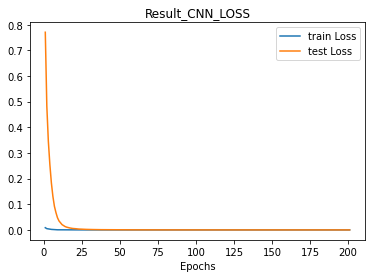

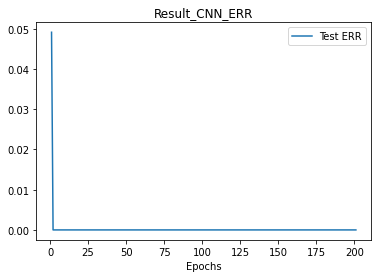

<Figure size 432x288 with 0 Axes>

In [17]:
print("Training start")

train_loss_list=[]
test_loss_list=[]

x_step=[]
y_err=[]

for epoch in range(num_epochs+1):
    for i, train_data in enumerate(train_loader):

      tain_loss = 0.0

      train_accent, train_label = train_data

      train_accent=train_accent.to(device)
      train_label=train_label.to(device)
      #print(train_accent, train_label)

      optimizer.zero_grad()

      hypothesis = cnn_model(train_accent).to(device)

      trn_loss = criterion(hypothesis, train_label)

      trn_loss.backward()
      optimizer.step()

      tain_loss+=trn_loss

      with torch.no_grad():

        test_loss=0.0
        correct = 0
        total = 0

        for j,test_data in enumerate(test_loader):

          test_accent, test_label = test_data

          test_accent=test_accent.to(device)
          test_label=test_label.to(device)
          #print(test_accent,test_label)

          prediction = cnn_model(test_accent)
          tst_loss = criterion(prediction, test_label)
          _, predicted = torch.max(prediction.data, 1)

          test_loss+=tst_loss*len(test_label)
          total += test_label.size(0)
          correct += (predicted == test_label).sum()

      correct = int(correct)
      total = int(total)

    if epoch % 20 ==0:
        print('Epoch: {:4d}/{} | train loss: {:.6f}'.format(epoch, num_epochs, tain_loss / 100))
        print("Epoch: {:4d}/{} | test loss: {:.6f}".format(epoch, num_epochs, test_loss / total))
        print('[Testset] ERR: %f | ACC: %f (%d / %d)' % (1 - (correct / total), correct / total, correct, total))
        print()

    train_loss_list.append(tain_loss/100)
    test_loss_list.append(test_loss/total)
    train_loss = 0.0

    x_step.append(epoch+1)
    y_err.append(1 - (correct / total))

plt.plot(x_step, train_loss_list, label = "train Loss")
plt.plot(x_step, test_loss_list, label = "test Loss")
plt.xlabel('Epochs')
plt.title('Result_CNN_LOSS')
plt.legend()
plt.savefig('Result_CNN_LOSS.png')
plt.show()
plt.clf()

plt.plot(x_step, y_err, label = "Test ERR")
plt.xlabel('Epochs')
plt.title('Result_CNN_ERR')
plt.legend()
plt.savefig('Result_CNN_ERR.png')
plt.show()
plt.clf()